#IRWA Project Part 1 and 2

Group team: G_101_7

Group members:

*   Mireia Carbó
*   Aitana González
*   Raquel Sans

# 0. Setup and Imports

In [1]:
### CONNECT TO DRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### IMPORTS

import json
import csv
import pandas as pd
import numpy as np
import re
import datetime
###
import nltk
nltk.download('stopwords')
###
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import warnings
warnings.filterwarnings('ignore')
###
from wordcloud import WordCloud
import matplotlib.pyplot as plt
###

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
### UPLOADS OF DOCS

docs_path_json = '/content/drive/Shareddrives/IRWA/Part2/IRWA_data_2023/Rus_Ukr_war_data.json'
docs_path_csv = '/content/drive/Shareddrives/IRWA/Part2/IRWA_data_2023/Rus_Ukr_war_data_ids.csv'
data_path_ev = '/content/drive/Shareddrives/IRWA/Part2/IRWA_data_2023/Evaluation_gt.csv'

# 1. Funciones desarrolladas

### Implementaciones Parte 1

In [4]:
### FUNCTIONS TO READ DATA (WITH DESIRED FORMAT)

def read_json_to_dict(json_to_trans):
  trans_to_dict = [json.loads(line) for line in open(json_to_trans, 'r')]
  return trans_to_dict

def read_csv_to_dict(csv_to_trans):
  data_col_names = ['doc', 'id']
  csv_read = pd.read_csv(csv_to_trans, sep="\t", names=data_col_names)
  trans_to_dict = csv_read.to_dict('records')
  return trans_to_dict

In [5]:
### CLEAN FUNCTION

def clean(text):
  # Transform to lowercase
  cleanTxt = text.lower()

  # Removing the urls from tweets, starts with https
  cleanTxt = re.sub('https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  # Removing the entire hashtags, starts with '#'
  cleanTxt = re.sub(r'#\w+\s*', '', cleanTxt)

  # Removing nonalphanumeric
  cleanTxt = re.sub(r'[\W]+', ' ', cleanTxt)
  cleanTxt = re.sub(r'[\_]+', '', cleanTxt)

  return cleanTxt

In [6]:
### BUILD TERMS FUNCTION

def build_terms(text):
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words("english"))

  # Clean text
  text = clean(text)

  # Tokenize the text to get a list of terms
  text = text.split()

  # Eliminate the stopwords (HINT: use List Comprehension)
  text = [word for word in text if word not in stop_words]

  # Perform stemming (HINT: use List Comprehension)
  text = [stemmer.stem(word) for word in text]

  return text

In [7]:
### FUNCTION TO OBTAIN THE DIFFERENT WORDS OF A HASHTAG

def separate_by_words(input_string):
    words = re.findall(r'[A-Z][a-z]*', input_string)

    # If there is only one or none words
    if (words == None or len(words) == 0):
      return input_string

    # If there are 2 or more identified words
    else:
      return ' '.join(words)

In [8]:
### FUNCTION TO OBTAIN THE ORIGINAL HASHTAGS OF A TWEET (IN A LIST)

def getHashtagsFromTweet_Original(tweet):
  length_hashtags = len(tweet["entities"]["hashtags"]) # number of hashtags used in the tweet
  hashtags = [] # empty hashtag list

  # Loop the list of hashtags used in the tweet
  for i in range(length_hashtags):
    hashtags.append('#' + tweet["entities"]["hashtags"][i]["text"])

  # Return the list of hashtags used
  return hashtags

In [9]:
### FUNCTION TO OBTAIN THE HASHTAGS OF A TWEET (IN A LIST)

def getHashtagsFromTweet(tweet):
  length_hashtags = len(tweet["entities"]["hashtags"]) # number of hashtags used in the tweet
  hashtags = [] #empty hashtag list

  # Loop the list of hashtags used in the tweet
  for i in range(length_hashtags):
    hash = separate_by_words(tweet["entities"]["hashtags"][i]["text"])
    hashtags.append(hash)

  # Return the list of hashtags used
  return hashtags

In [10]:
# FUNCTION TO TRANSFORM A LIST OF STRINGS TO A UNIQUE STRING

def string_concat(stringList):
  return ' '.join(stringList)

In [11]:
def prepare_hashtag_for_text(list_processed_hasthags):
  # Join the hashtags into a single string and convert to lowercase
  all_hashtags_text = ' '.join(list_processed_hasthags).lower()

  # Split the text into individual words
  words = all_hashtags_text.split()
  return words

In [12]:
# FUNCTION TO OBTAIN THE DESIRED INFORMATION OF EACH TWEET (IN A DICTIONARY)

def getTweetInfo(tweet):
  tweet_dict = {}
  # Tweet ID
  tweet_dict['ID'] = tweet['id']
  # Text of the Tweet
  tweet_dict['Tweet'] = tweet['full_text']
  # Pre-Processed Tweet
  tweet_dict['PreProcessed_Tweet'] = build_terms(tweet['full_text']) + prepare_hashtag_for_text(getHashtagsFromTweet(tweet))
  # User's Tweet
  tweet_dict['Username'] = '@' + tweet['user']['screen_name']
  # Date of publication of the Tweet (with desired format)
  original = datetime.datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S +0000 %Y')
  tweet_dict['Date'] = original.strftime('%d/%m/%Y %H:%M:%S')
  # Hashtags
  tweet_dict['Hashtags'] = getHashtagsFromTweet_Original(tweet)
  # Processed Hashtags
  tweet_dict['Processed_Hashtags'] = getHashtagsFromTweet(tweet)
  # Num of Likes of the Tweet
  tweet_dict['Likes'] = tweet['favorite_count']
  # Num of Retweets of the Tweet
  tweet_dict['Retweets'] = tweet['retweet_count']
  # URL (Tweet Link) -> The pattern is always https://twitter.com/screen_name/status/id
  tweet_dict['URL'] = 'https://twitter.com/' + tweet['user']['screen_name'] + '/status/' + tweet['id_str']
  return tweet_dict

In [13]:
### FUNCTION TO CREATE A DICTIONARY THAT WILL CONTAIN ALL THE TWEET'S INFORMATION (DICTIONARY OF DICTIONARIES)

def tweets_dict(json_doc, csv_doc):
  tweets = {} # empty dictionary

  # for each tweet in the json_doc
  for t in json_doc:

    # we look to match the tweet id from json_doc with the id from data_csv
    for d in csv_doc:
      if t['id'] == d['id']:
        index = d['doc']
        break

    # Transform the original tweet into the format we want and save it with the key from data_csv (doc_xxxx)
    tweets[index] = getTweetInfo(t)

  # return the complete dictionary of preprocessed tweets
  return tweets

### Implementaciones Parte 2

In [14]:
# create_index

def create_index(lines):
    """
    Implement the inverted index

    Argument:
    lines -- collection of Wikipedia articles

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    title_index = {}  # dictionary to map page titles to page ids
    for line in lines:  # Remember, lines contain all documents: article-id | article-title | article-body
        line_arr = line.split("|")
        page_id = int(line_arr[0])
        terms = build_terms(''.join(line_arr[1:])) # page_title + page_text
        title = line_arr[1]
        title_index[page_id]=title  ## we do not need to apply get terms to title because it used only to print titles and not in the index

        ## ===============================================================
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0,
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list

        ## START CODE
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [page_id, array('I', [position])] #'I' indicates unsigned int (int in Python)

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        ## END CODE

    return index, title_index

In [15]:
#search

def search(query, index):
    """
    The output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
    ## START DODE
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]
            # docs = docs Union term_docs
            docs = docs.union(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    return docs

In [16]:
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    lines -- collection of Wikipedia articles
    num_documents -- total number of documents

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    title_index = defaultdict(str)
    idf = defaultdict(float)

    for line in lines:
        line_arr = line.split("|")
        page_id = int(line_arr[0])
        terms = build_terms(''.join(line_arr[1:]))  # page_title + page_text
        title = line_arr[1]
        title_index[page_id] = title

        ## ===============================================================
        ## create the index for the **current page** and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0,
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms):  ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term] = [page_id, array('I', [position])] #'I' indicates unsigned int (int in Python)

        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document.
            # posting ==> [current_doc, [list of positions]]
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf, title_index

In [17]:
# rank_documents

def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=(query_terms_count[term] / query_norm) * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    result_scores = [x[0] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        #docs = search_tf_idf(query, index, title_index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, result_scores

In [18]:
#search_tf_idf
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs=[posting[0] for posting in index[term]]

            # docs = docs Union term_docs
            docs = docs.union(set(term_docs))
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, ranked_scores = rank_documents(query, docs, index, idf, tf)
    return ranked_docs, ranked_scores

In [19]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    relevant = sum(doc_score == 1)
    return float(relevant) / k

In [20]:
def recall_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order) # y_true
    relevant = doc_score[:k].sum()
    total_relevant = doc_score.sum()
    if total_relevant == 0:
      return 0.0
    return relevant / total_relevant

In [21]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

In [22]:
def f1_score_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    F1-Score @k : float

    """
    precision = precision_at_k(doc_score, y_score, k)
    recall = recall_at_k(doc_score, y_score, k)

    if precision + recall == 0:
        return 0

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [23]:
def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res['query_id'].unique():  # loop over all query id
        curr_data = search_res[search_res['query_id'] == q] # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data['ground_truth']), np.array(curr_data['score']), k))  #append average precision for current query
    return np.sum(avp) / len(avp)  # return mean average precision

In [24]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

In [25]:
# mrr_at_k
def mrr_at_k(search_results, k):
  RRs = []
  for q in search_results['query_id'].unique():  # loop over all query ids
      labels = np.array(search_results[search_results['query_id'] == q]["ground_truth"])  # get labels for current query
      scores = np.array(search_results[search_results['query_id'] == q]["score"])  # get predicted score for current query
      RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
  return np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k

In [26]:
# dcg_at k
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k

In [27]:
# ndcg_at_k
def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

# Solución

### Parte 1

In [28]:
# Read data and store it
data_json = read_json_to_dict(docs_path_json)
data_csv = read_csv_to_dict(docs_path_csv)

In [29]:
# Generation of tweets dictionary
get_tweets = tweets_dict(data_json, data_csv)

#### Comprobaciones Parte 1

In [30]:
get_tweets['doc_3904']

{'ID': 1575164742859378689,
 'Tweet': 'Whether you are visiting Nigeria or you living in Nigeria, we understand the importance of information; we know that a lot of our customers sometimes are looking for ideas of where to go and spend their leisure.\n#WelcomeToIndonesia_NCTDREAM #logistics #usa #UkraineRussiaWar #uk https://t.co/T3I9gNVpne',
 'PreProcessed_Tweet': ['whether',
  'visit',
  'nigeria',
  'live',
  'nigeria',
  'understand',
  'import',
  'inform',
  'know',
  'lot',
  'custom',
  'sometim',
  'look',
  'idea',
  'go',
  'spend',
  'leisur',
  'welcome',
  'to',
  'indonesia',
  'n',
  'c',
  't',
  'd',
  'r',
  'e',
  'a',
  'm',
  'logistics',
  'usa',
  'ukraine',
  'russia',
  'war',
  'uk'],
 'Username': '@simpreslogistis',
 'Date': '28/09/2022 16:45:14',
 'Hashtags': ['#WelcomeToIndonesia_NCTDREAM',
  '#logistics',
  '#usa',
  '#UkraineRussiaWar',
  '#uk'],
 'Processed_Hashtags': ['Welcome To Indonesia N C T D R E A M',
  'logistics',
  'usa',
  'Ukraine Russia War

In [31]:
# TWEET : Original vs Pre- Processed
print(get_tweets['doc_3904']["Tweet"] + "\n")
print(string_concat(get_tweets['doc_3904']["PreProcessed_Tweet"]))

Whether you are visiting Nigeria or you living in Nigeria, we understand the importance of information; we know that a lot of our customers sometimes are looking for ideas of where to go and spend their leisure.
#WelcomeToIndonesia_NCTDREAM #logistics #usa #UkraineRussiaWar #uk https://t.co/T3I9gNVpne

whether visit nigeria live nigeria understand import inform know lot custom sometim look idea go spend leisur welcome to indonesia n c t d r e a m logistics usa ukraine russia war uk


In [32]:
# HASHTAG: Original vs Pre-Processed vs 2n Pre-Processed
print(get_tweets['doc_3904']["Hashtags"], "\n")
print(get_tweets['doc_3904']["Processed_Hashtags"], "\n")
print(prepare_hashtag_for_text(get_tweets['doc_3904']["Processed_Hashtags"]))

['#WelcomeToIndonesia_NCTDREAM', '#logistics', '#usa', '#UkraineRussiaWar', '#uk'] 

['Welcome To Indonesia N C T D R E A M', 'logistics', 'usa', 'Ukraine Russia War', 'uk'] 

['welcome', 'to', 'indonesia', 'n', 'c', 't', 'd', 'r', 'e', 'a', 'm', 'logistics', 'usa', 'ukraine', 'russia', 'war', 'uk']


### Implementaciones Parte 2

#### Indexing

In [33]:
tweet_lines_list = []
for key_tweet, values_tweet in get_tweets.items():
  tweet_id = str(values_tweet['ID'])
  doc_id = key_tweet
  tweet_text = values_tweet['PreProcessed_Tweet']
  tweet_text = string_concat(tweet_text)
  tweet_line = "|".join([tweet_id, doc_id, tweet_text])
  tweet_lines_list.append(tweet_line)

print(tweet_lines_list[1])

1575918081461080065|doc_2|the arm forc liber villag urban territori commun region drobysheve lymansk donetsk ukraine russia war ukraine war ukraine ukraine will win ukrainian army ukrainecounteroffensive ukraine war news slava ukra stand with ukraine


In [34]:
import time
start_time = time.time()
index1, title_index1 = create_index(tweet_lines_list)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 4.3 seconds


In [35]:
print("Insert your query (i.e.: presidents visiting Kyiv):\n")
query_try = input()
docs = search(query_try, index1)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n======================".format(top, len(docs)))
for d_id in docs[:top]:
    print("\n\033[1mtweet_id = {} - tweet_title: {}\033[0m".format(d_id, title_index1[d_id]))
    print("tweet_text: {}".format(get_tweets[title_index1[d_id]]['Tweet']))

Insert your query (i.e.: presidents visiting Kyiv):

presidents visiting Kyiv

Sample of 10 results out of 206 for the searched query:

tweet_id = 1575910966206038016 - tweet_title: doc_58
tweet_text: As Europe prepares to defend Ukraine French leaders are donning masks in their traditional battle flag colors #UkraineRussiaWar #UkraineWillWin #BidenWorstPresidentInHistory https://t.co/EWMecu3DAP

tweet_id = 1575913989195718657 - tweet_title: doc_30
tweet_text: Former Russian Prime Minister Mikhail Kasyanov believes that Russian President Vladimir #Putin could step down from his position and flee #Russia in a few months.
#Ukraine️ #UkraineRussiaWar #NATO #Putler https://t.co/VzzStxdktj

tweet_id = 1575905170952982529 - tweet_title: doc_131
tweet_text: ⚡️BREAKING: After Putin's unilateral declaration of the annexation of occupied Ukraine, President Volodymyr Zelensky has announced that Kyiv has formally requested to join NATO.
https://t.co/aRQwsKpZlL

#WARINUKRAINE #UKRAINEWAR #UKRAINERU

In [36]:
start_time = time.time()
num_tweets = len(tweet_lines_list)
index2, tf, df, idf, title_index2 = create_index_tfidf(tweet_lines_list, num_tweets)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 299.9 seconds


In [37]:
## OUR QUERY 1
print("**QUERY 1**\n")
new_q1 = "Eastern separatists groups"
print(new_q1)
ranked_docs, ranked_scores = search_tf_idf(new_q1, index2)
top = 10
i = 0
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("\n\033[1mtweet_id = {} - tweet_title: {} - score: {}\033[0m".format(d_id, title_index2[d_id], ranked_scores[i]))
    print("\033[1mtweet_text:\033[0m {}".format(get_tweets[title_index2[d_id]]['Tweet']))
    i = i+1

**QUERY 1**

Eastern separatists groups

Top 10 results out of 55 for the searched query:


tweet_id = 1575842840768569344 - tweet_title: doc_538 - score: 9.068672454039067
tweet_text: The spokesman of the Eastern group of troops Cherevaty reported that the encirclement of the Russian group near Lyman in Donetsk region is "at the stage of completion"
#UkraineRussiaWar https://t.co/drAsg9PDes

tweet_id = 1575818569857658880 - tweet_title: doc_812 - score: 7.9992014749313505
tweet_text: First Official APU Report on Lyman:  "The operation to encircle the Russian group in the Estuary is at the completion stage" —  Sergey Cherevaty, Eastern Grouping 

#UkraineRussiaWar 
#OSINT
#Fellas #NAFO

tweet_id = 1575821202064834560 - tweet_title: doc_776 - score: 7.348035242319465
tweet_text: Cherevaty, the spokesperson of the Eastern group of troops, reported the encirclement of the #Russian group near #Lyman in the #Donetsk region is “at the stage of completion.” #Ukraine #UkraineRussiaWar #Ukraine

In [38]:
## QUERY 2
print("**QUERY 2**\n")
new_q2 = "Humanitarian impact"
print(new_q2)
ranked_docs, ranked_scores = search_tf_idf(new_q2, index2)
top = 10
i = 0
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("\n\033[1mtweet_id = {} - tweet_title: {} - score: {}\033[0m".format(d_id, title_index2[d_id], ranked_scores[i]))
    print("\033[1mtweet_text:\033[0m {}".format(get_tweets[title_index2[d_id]]['Tweet']))
    i = i+1

**QUERY 2**

Humanitarian impact

Top 10 results out of 30 for the searched query:


tweet_id = 1575722456823738370 - tweet_title: doc_1426 - score: 7.143300400638406
tweet_text: ❗Russian missile attack on the humanitarian convoy from Zaporizhzhia to occupied territories. People were heading to rescue their relatives left in russia-controlled areas and provide humanitarian aid.

#UkraineRussiaWar https://t.co/ZlYntJRliA

tweet_id = 1575684580295970817 - tweet_title: doc_1540 - score: 6.736325307562501
tweet_text: Here’s how the war in Ukraine 🇺🇦 is impacting world trade and investment acc to @wef 

#SupplyChain #Procurement #economy #UkraineRussiaWar #foodcrisis #logistics https://t.co/NNCRHhTFsW

tweet_id = 1575417601781530626 - tweet_title: doc_2753 - score: 5.339770060872714
tweet_text: India and China opting to make positive impact in Ukraine 

https://t.co/Pi8PpSrMg3

#TheIsland #TheIslandnewspaper #TheIslandOnline #features #featurestory #India  #China #positiveimpact #Ukraine #U

In [39]:
## QUERY 3
print("**QUERY 3**\n")
new_q3 = "Media coverage of war"
print(new_q3)
ranked_docs, ranked_scores = search_tf_idf(new_q3, index2)
top = 10
i = 0
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("\n\033[1mtweet_id = {} - tweet_title: {} - score: {}\033[0m".format(d_id, title_index2[d_id], ranked_scores[i]))
    print("\033[1mtweet_text:\033[0m {}".format(get_tweets[title_index2[d_id]]['Tweet']))
    i = i+1

**QUERY 3**

Media coverage of war

Top 10 results out of 3929 for the searched query:


tweet_id = 1575813822786551808 - tweet_title: doc_883 - score: 4.870877111750377
tweet_text: Ukraine is not better than Russia.
Today they killed 23 people in Rocket attack on a civil convoy.
Although I am against the invasion but I am also against western biased coverage that turns back on ukraine war crimes.
#UkraineRussiaWar 
#poundcrash

tweet_id = 1575242122684293120 - tweet_title: doc_3355 - score: 4.698775773590212
tweet_text: You might think it's conspiracist nonsense to accuse Biden of sabotaging #NordStream2 which media all blame on Russia, but look in the comments at the video of him threatening to do just that: shows nothing western media claims on #UkraineRussiaWar can be trusted #NordstreamLeaks https://t.co/lH3kdGaMEI

tweet_id = 1575810496116117504 - tweet_title: doc_926 - score: 4.592619972554513
tweet_text: Coming soon on SGN, live coverage as Putin holds treaty ceremony to offici

In [40]:
## QUERY 4
print("**QUERY 4**\n")
new_q4 = "Negotiations in war"
print(new_q4)
ranked_docs, ranked_scores = search_tf_idf(new_q4, index2)
top = 10
i = 0
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("\n\033[1mtweet_id = {} - tweet_title: {} - score: {}\033[0m".format(d_id, title_index2[d_id], ranked_scores[i]))
    print("\033[1mtweet_text:\033[0m {}".format(get_tweets[title_index2[d_id]]['Tweet']))
    i = i+1

**QUERY 4**

Negotiations in war

Top 10 results out of 3928 for the searched query:


tweet_id = 1575324772199710720 - tweet_title: doc_3067 - score: 6.153608314723627
tweet_text: Noam Chomsky: "Most of the world... is calling for #Negotiations now, while the US insists that priority must be to severely weaken #Russia, hence no negotiations." (1/2)

#Ukraine #UkraineRussiaWar
https://t.co/QB1QlH5Fdz

tweet_id = 1575776384324374528 - tweet_title: doc_1218 - score: 4.730562863510461
tweet_text: #EXCLUSIVE : Dmitry Peskov on the possibility of negotiations with Volodymyr Zelensky: #Kyiv has left the negotiation track, #Moscow's demands do not change, the Special Military Operation (SVO) will continue...

#RussianArmy #UkraineRussiaWar #UkraineWar #UkrainianArmy

tweet_id = 1575845160134451200 - tweet_title: doc_515 - score: 4.120218268516906
tweet_text: 3o/9
🇺🇦⚡️🇷🇺
negotiating table".
But we already know that negotiations with #Russia will not last more than one round of machine gun fire

In [41]:
## QUERY 5
print("**QUERY 5**\n")
new_q5 = "Russian propaganda and disinformation"
print(new_q5)
ranked_docs, ranked_scores = search_tf_idf(new_q5, index2)
top = 10
i = 0
print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("\n\033[1mtweet_id = {} - tweet_title: {} - score: {}\033[0m".format(d_id, title_index2[d_id], ranked_scores[i]))
    print("\033[1mtweet_text:\033[0m {}".format(get_tweets[title_index2[d_id]]['Tweet']))
    i = i+1

**QUERY 5**

Russian propaganda and disinformation

Top 10 results out of 1509 for the searched query:


tweet_id = 1575413884617383936 - tweet_title: doc_2762 - score: 19.435317936601205
tweet_text: Fake news - A typical British propaganda and disinformation

#Ukraine #Ukrainewar #UkraineRussiaWar #Propaganda #Fake #Disinformation https://t.co/lFVEGyLhfK

tweet_id = 1575245412423897105 - tweet_title: doc_3324 - score: 7.953635177621761
tweet_text: @RebelNewsOnline How about a concerted effort of disinformation to the benefit of #Russiangas? #ONGT #natgas #UkraineRussiaWar https://t.co/OrC5gFvxYo

tweet_id = 1575793780350889984 - tweet_title: doc_1098 - score: 7.240923415464685
tweet_text: #UkraineRussiaWar #Kharkiv #Izium #warehouse #russians #propaganda #referendum russian warehouse with ammunition, propaganda leaflets found in Izium https://t.co/GNj3TUoysk

tweet_id = 1575228605088468992 - tweet_title: doc_3439 - score: 7.028208537130871
tweet_text: US State Department: The claim th

#### Evaluation

In [42]:
# baseline with 3 queries and the ground truth files for each query
evaluation_csv = pd.read_csv(data_path_ev)

In [43]:
print_result = evaluation_csv["label"].unique()
print("The ground truth of our dataset is composed of {} Relevance Levels: {}".format(len(print_result), sorted(print_result)))

The ground truth of our dataset is composed of 2 Relevance Levels: [0, 1]


####[GIVEN QUERIES]

In [44]:
# queries definition
q1 = "tank in Kharkiv"
q2 = "Nord Stream pipeline"
q3 = "annexation territories Russia"

# create the dataframe with this 3 queries
queries = [q1,q2,q3]
queries_df = pd.DataFrame(columns = ["tweet_id", "query_id", "score", 'ground_truth'])
list_to_ev = []

# get the tweets_id
doc_xxx = evaluation_csv["doc"].values
labels_doc_xxx = evaluation_csv["label"].values
for i in range(len(evaluation_csv["doc"])):
  list_to_ev.append((doc_xxx[i],get_tweets[doc_xxx[i]]['ID'], labels_doc_xxx[i]))

In [45]:
for i in range(len(queries)):
  ranked_docs, ranked_scores = search_tf_idf(queries[i], index2)

  for j in range(len(list_to_ev)):

    if (i == 2 and j >= 0 and j <= 19):
      try:
        queries_df = queries_df.append({"tweet_id": list_to_ev[j][1], "query_id": int(i+1), "score": ranked_scores[ranked_docs.index(list_to_ev[j][1])], "ground_truth": int(list_to_ev[j][2])}, ignore_index=True)
      except:
        queries_df = queries_df.append({"tweet_id": list_to_ev[j][1], "query_id": int(i+1), "score": 0, "ground_truth": int(list_to_ev[j][2])}, ignore_index=True)


    elif (i == 1 and j >= 20 and j <= 39):
      try:
        queries_df = queries_df.append({"tweet_id": list_to_ev[j][1], "query_id": int(i+1), "score": ranked_scores[ranked_docs.index(list_to_ev[j][1])], "ground_truth": int(list_to_ev[j][2])}, ignore_index=True)
      except:
        queries_df = queries_df.append({"tweet_id": list_to_ev[j][1], "query_id": int(i+1), "score": 0, "ground_truth": int(list_to_ev[j][2])}, ignore_index=True)

    elif (i == 0 and j >= 40 and j <= 59):
      try:
        queries_df = queries_df.append({"tweet_id": list_to_ev[j][1], "query_id": int(i+1), "score": ranked_scores[ranked_docs.index(list_to_ev[j][1])], "ground_truth": int(list_to_ev[j][2])}, ignore_index=True)
      except:
        queries_df = queries_df.append({"tweet_id": list_to_ev[j][1], "query_id": int(i+1), "score": 0, "ground_truth": int(list_to_ev[j][2])}, ignore_index=True)

# we sort by score, respecting the query_id value
queries_df = queries_df.sort_values(by=['query_id','score'], ascending = [True, False])

queries_df.head()

,tweet_id,query_id,score,ground_truth
0,1.575529e+18,1.0,4.698085,1.0
1,1.575448e+18,1.0,3.713707,1.0
6,1.575435e+18,1.0,3.266190,1.0
10,1.575754e+18,1.0,2.870063,0.0
3,1.575834e+18,1.0,2.164526,1.0


In [46]:
queries_df = queries_df.astype({'query_id': 'int64'})
queries_df = queries_df.astype({'ground_truth': 'int64'})
queries_df = queries_df.astype({'tweet_id': 'int64'})
queries_df.head()

,tweet_id,query_id,score,ground_truth
0,1575528927245770752,1,4.698085,1
1,1575448045457707008,1,3.713707,1
6,1575435463682363392,1,3.266190,1
10,1575753840233701376,1,2.870063,0
3,1575834054905462784,1,2.164526,1


In [47]:
k = [4, 8, 12, 16, 20]
for k_j in k:
  for i in range(len(queries)):
    result = queries_df[queries_df["query_id"] == i+1]
    print("Query{} -  Precision@{}: {}".format(i+1, k_j, precision_at_k(result["ground_truth"], result["score"], k_j)))

Query1 -  Precision@4: 0.75
Query2 -  Precision@4: 1.0
Query3 -  Precision@4: 1.0
Query1 -  Precision@8: 0.875
Query2 -  Precision@8: 1.0
Query3 -  Precision@8: 1.0
Query1 -  Precision@12: 0.75
Query2 -  Precision@12: 0.8333333333333334
Query3 -  Precision@12: 0.8333333333333334
Query1 -  Precision@16: 0.625
Query2 -  Precision@16: 0.625
Query3 -  Precision@16: 0.625
Query1 -  Precision@20: 0.5
Query2 -  Precision@20: 0.5
Query3 -  Precision@20: 0.5


In [48]:
k = [4, 8, 12, 16, 20]
for k_j in k:
  for i in range(len(queries)):
    result = queries_df[queries_df["query_id"] == i+1]
    print("Query{} -  Recall@{}: {}".format(i+1, k_j, recall_at_k(result["ground_truth"], result["score"], k_j)))

Query1 -  Recall@4: 0.3
Query2 -  Recall@4: 0.4
Query3 -  Recall@4: 0.4
Query1 -  Recall@8: 0.7
Query2 -  Recall@8: 0.8
Query3 -  Recall@8: 0.8
Query1 -  Recall@12: 0.9
Query2 -  Recall@12: 1.0
Query3 -  Recall@12: 1.0
Query1 -  Recall@16: 1.0
Query2 -  Recall@16: 1.0
Query3 -  Recall@16: 1.0
Query1 -  Recall@20: 1.0
Query2 -  Recall@20: 1.0
Query3 -  Recall@20: 1.0


In [49]:
k = 20
for i in range(len(queries)):
  result = queries_df[queries_df["query_id"] == i+1]
  print("Query{} -  Average Precision@{}: {}".format(i+1, k, avg_precision_at_k(np.array(result["ground_truth"]), np.array(result["score"]), k)))

Query1 -  Average Precision@20: 0.8684706959706959
Query2 -  Average Precision@20: 1.0
Query3 -  Average Precision@20: 1.0


In [50]:
from sklearn.metrics import average_precision_score
k = 20
for i in range(len(queries)):
  result = queries_df[queries_df["query_id"] == i+1]
  print("Query{} -  Average Precision@{} (python function): {}".format(i+1, k, average_precision_score(np.array(result["ground_truth"]), np.array(result["score"][:k])), k))

Query1 -  Average Precision@20 (python function): 0.8708516483516483
Query2 -  Average Precision@20 (python function): 0.9999999999999999
Query3 -  Average Precision@20 (python function): 1.0


In [51]:
k = [4, 8, 12, 16, 20]
for k_j in k:
  for i in range(len(queries)):
    result = queries_df[queries_df["query_id"] == i+1]
    print("Query{} -  F1-Score@{}: {}".format(i+1, k_j, f1_score_at_k(np.array(result["ground_truth"]), np.array(result["score"]), k_j)))

Query1 -  F1-Score@4: 0.4285714285714285
Query2 -  F1-Score@4: 0.5714285714285715
Query3 -  F1-Score@4: 0.5714285714285715
Query1 -  F1-Score@8: 0.7777777777777777
Query2 -  F1-Score@8: 0.888888888888889
Query3 -  F1-Score@8: 0.888888888888889
Query1 -  F1-Score@12: 0.8181818181818182
Query2 -  F1-Score@12: 0.9090909090909091
Query3 -  F1-Score@12: 0.9090909090909091
Query1 -  F1-Score@16: 0.7692307692307693
Query2 -  F1-Score@16: 0.7692307692307693
Query3 -  F1-Score@16: 0.7692307692307693
Query1 -  F1-Score@20: 0.6666666666666666
Query2 -  F1-Score@20: 0.6666666666666666
Query3 -  F1-Score@20: 0.6666666666666666


In [52]:
k = [4, 8, 12, 16, 20]
for k_j in k:
  print("MAP@{}: {}".format(k_j,  map_at_k(queries_df,k_j)))

MAP@4: 0.3666666666666667
MAP@8: 0.7455158730158731
MAP@12: 0.930515873015873
MAP@16: 0.9561568986568987
MAP@20: 0.9561568986568987


In [53]:
k = [4, 8, 12, 16, 20]
for k_j in k:
  print("MRR@{}: {}".format(k_j,  mrr_at_k(queries_df,k_j)))

MRR@4: 1.0
MRR@8: 1.0
MRR@12: 1.0
MRR@16: 1.0
MRR@20: 1.0


In [54]:
k = [4, 8, 12, 16, 20]
for k_j in k:
  for i in range(len(queries)):
    result = queries_df[queries_df["query_id"] == i+1]
    labels = np.array(result["ground_truth"])
    scores = np.array(result["score"])
    ndcg_k = np.round(ndcg_at_k(labels, scores, k_j), 4)
    print("Query{} -  NDCG@{}: {}".format(i+1, k_j, ndcg_k))

Query1 -  NDCG@4: 0.8319
Query2 -  NDCG@4: 1.0
Query3 -  NDCG@4: 1.0
Query1 -  NDCG@8: 0.8911
Query2 -  NDCG@8: 1.0
Query3 -  NDCG@8: 1.0
Query1 -  NDCG@12: 0.8984
Query2 -  NDCG@12: 1.0
Query3 -  NDCG@12: 1.0
Query1 -  NDCG@16: 0.9562
Query2 -  NDCG@16: 1.0
Query3 -  NDCG@16: 1.0
Query1 -  NDCG@20: 0.9562
Query2 -  NDCG@20: 1.0
Query3 -  NDCG@20: 1.0


####[OUR QUERIES]

In [55]:
new_q1 = "Eastern separatists groups"
new_q2 = "Humanitarian impact"
new_q3 = "Media coverage of war"
new_q4 = "Negotiations in war"
new_q5 = "Russian propaganda and disinformation"

new_queries = [new_q1,new_q2,new_q3,new_q4,new_q5]
new_queries_df = pd.DataFrame(columns = ["tweet_id", "query_id", "score", 'ground_truth'])
top = 20

for i in range(len(new_queries)):
  new_ranked_docs, new_ranked_scores = search_tf_idf(new_queries[i], index2)
  for j, tweet_id in enumerate(new_ranked_docs[:top]):
        new_queries_df = new_queries_df.append({"tweet_id": tweet_id, "query_id": str(i+1), "score": ranked_scores[j]}, ignore_index=True)

# we sort by score, respecting the query_id value
new_queries_df = new_queries_df.sort_values(by=['query_id','score'], ascending = [True, False])

new_queries_df.head()


,tweet_id,query_id,score,ground_truth
0,1575842840768569344,1,3.282387,NaN
1,1575818569857658880,1,3.129791,NaN
2,1575821202064834560,1,2.879615,NaN
3,1575820237010006017,1,2.879615,NaN
4,1575180675002486785,1,2.725980,NaN


In [56]:
new_ground_truth = [1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
                    0, 0, 0, 0, 1, 0, 0, 1, 1, 1,

                    1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
                    0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

                    0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
                    1, 1, 0, 0, 0, 1, 0, 0, 0, 0,

                    0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
                    1, 0, 1, 0, 0, 0, 1, 1, 0, 0,

                    1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
                    0, 1, 0, 0, 1, 0, 1, 0, 1, 1]

new_queries_df['ground_truth'] = new_ground_truth
new_queries_df.head()

,tweet_id,query_id,score,ground_truth
0,1575842840768569344,1,3.282387,1
1,1575818569857658880,1,3.129791,1
2,1575821202064834560,1,2.879615,1
3,1575820237010006017,1,2.879615,1
4,1575180675002486785,1,2.725980,0


In [57]:
new_queries_df = new_queries_df.astype({'query_id': 'int64'})
new_queries_df = new_queries_df.astype({'ground_truth': 'int64'})
new_queries_df = new_queries_df.astype({'tweet_id': 'int64'})
new_queries_df.head()

,tweet_id,query_id,score,ground_truth
0,1575842840768569344,1,3.282387,1
1,1575818569857658880,1,3.129791,1
2,1575821202064834560,1,2.879615,1
3,1575820237010006017,1,2.879615,1
4,1575180675002486785,1,2.725980,0


In [58]:
new_k = [4, 8, 12, 16, 20]
for k_j in new_k:
  for i in range(len(new_queries)):
    new_result = new_queries_df[new_queries_df["query_id"] == i+1]
    print("Query{} -  Precision@{}: {}".format(i+1, k_j, precision_at_k(new_result["ground_truth"], new_result["score"], k_j)))

Query1 -  Precision@4: 1.0
Query2 -  Precision@4: 0.5
Query3 -  Precision@4: 0.5
Query4 -  Precision@4: 0.5
Query5 -  Precision@4: 0.75
Query1 -  Precision@8: 0.75
Query2 -  Precision@8: 0.625
Query3 -  Precision@8: 0.625
Query4 -  Precision@8: 0.5
Query5 -  Precision@8: 0.625
Query1 -  Precision@12: 0.5
Query2 -  Precision@12: 0.6666666666666666
Query3 -  Precision@12: 0.75
Query4 -  Precision@12: 0.5833333333333334
Query5 -  Precision@12: 0.5
Query1 -  Precision@16: 0.4375
Query2 -  Precision@16: 0.5625
Query3 -  Precision@16: 0.625
Query4 -  Precision@16: 0.5
Query5 -  Precision@16: 0.4375
Query1 -  Precision@20: 0.5
Query2 -  Precision@20: 0.5
Query3 -  Precision@20: 0.5
Query4 -  Precision@20: 0.5
Query5 -  Precision@20: 0.5


In [59]:
new_k = [4, 8, 12, 16, 20]
for k_j in new_k:
  for i in range(len(new_queries)):
    new_result = new_queries_df[new_queries_df["query_id"] == i+1]
    print("Query{} -  Recall@{}: {}".format(i+1, k_j, recall_at_k(new_result["ground_truth"], new_result["score"], k_j)))

Query1 -  Recall@4: 0.4
Query2 -  Recall@4: 0.2
Query3 -  Recall@4: 0.2
Query4 -  Recall@4: 0.2
Query5 -  Recall@4: 0.3
Query1 -  Recall@8: 0.6
Query2 -  Recall@8: 0.5
Query3 -  Recall@8: 0.5
Query4 -  Recall@8: 0.4
Query5 -  Recall@8: 0.5
Query1 -  Recall@12: 0.6
Query2 -  Recall@12: 0.8
Query3 -  Recall@12: 0.9
Query4 -  Recall@12: 0.7
Query5 -  Recall@12: 0.6
Query1 -  Recall@16: 0.7
Query2 -  Recall@16: 0.9
Query3 -  Recall@16: 1.0
Query4 -  Recall@16: 0.8
Query5 -  Recall@16: 0.7
Query1 -  Recall@20: 1.0
Query2 -  Recall@20: 1.0
Query3 -  Recall@20: 1.0
Query4 -  Recall@20: 1.0
Query5 -  Recall@20: 1.0


In [60]:
new_k = 20
for i in range(len(new_queries)):
  new_result = new_queries_df[new_queries_df["query_id"] == i+1]
  print("Query{} -  Average Precision@{}: {}".format(i+1, new_k, avg_precision_at_k(np.array(new_result["ground_truth"]), np.array(new_result["score"]), new_k)))

Query1 -  Average Precision@20: 0.7575271512113617
Query2 -  Average Precision@20: 0.670554298642534
Query3 -  Average Precision@20: 0.6098701298701299
Query4 -  Average Precision@20: 0.5729698028150041
Query5 -  Average Precision@20: 0.6145588235294117


In [61]:
from sklearn.metrics import average_precision_score
new_k = 20
for i in range(len(new_queries)):
  new_result = new_queries_df[new_queries_df["query_id"] == i+1]
  print("Query{} -  Average Precision@{} (python function): {}".format(i+1, new_k, average_precision_score(np.array(new_result["ground_truth"]), np.array(new_result["score"][:new_k])), new_k))

Query1 -  Average Precision@20 (python function): 0.7604511278195488
Query2 -  Average Precision@20 (python function): 0.6705542986425339
Query3 -  Average Precision@20 (python function): 0.6265367965367965
Query4 -  Average Precision@20 (python function): 0.5729698028150041
Query5 -  Average Precision@20 (python function): 0.6202605779153767


In [62]:
new_k = [4, 8, 12, 16, 20]
for k_j in new_k:
  for i in range(len(new_queries)):
    new_result = new_queries_df[new_queries_df["query_id"] == i+1]
    print("Query{} -  F1-Score@{}: {}".format(i+1, k_j, f1_score_at_k(np.array(new_result["ground_truth"]), np.array(new_result["score"]), k_j)))

Query1 -  F1-Score@4: 0.5714285714285715
Query2 -  F1-Score@4: 0.28571428571428575
Query3 -  F1-Score@4: 0.28571428571428575
Query4 -  F1-Score@4: 0.28571428571428575
Query5 -  F1-Score@4: 0.4285714285714285
Query1 -  F1-Score@8: 0.6666666666666665
Query2 -  F1-Score@8: 0.5555555555555556
Query3 -  F1-Score@8: 0.5555555555555556
Query4 -  F1-Score@8: 0.4444444444444445
Query5 -  F1-Score@8: 0.5555555555555556
Query1 -  F1-Score@12: 0.5454545454545454
Query2 -  F1-Score@12: 0.7272727272727272
Query3 -  F1-Score@12: 0.8181818181818182
Query4 -  F1-Score@12: 0.6363636363636365
Query5 -  F1-Score@12: 0.5454545454545454
Query1 -  F1-Score@16: 0.5384615384615384
Query2 -  F1-Score@16: 0.6923076923076923
Query3 -  F1-Score@16: 0.7692307692307693
Query4 -  F1-Score@16: 0.6153846153846154
Query5 -  F1-Score@16: 0.5384615384615384
Query1 -  F1-Score@20: 0.6666666666666666
Query2 -  F1-Score@20: 0.6666666666666666
Query3 -  F1-Score@20: 0.6666666666666666
Query4 -  F1-Score@20: 0.6666666666666666

In [63]:
new_k = [4, 8, 12, 16, 20]
for k_j in new_k:
  print("MAP@{}: {}".format(k_j,  map_at_k(new_queries_df,k_j)))

MAP@4: 0.195
MAP@8: 0.3537380952380952
MAP@12: 0.49712193362193363
MAP@16: 0.5544424464424464
MAP@20: 0.6450960412136884


In [64]:
new_k = [4, 8, 12, 16, 20]
for k_j in new_k:
  print("MRR@{}: {}".format(k_j,  mrr_at_k(new_queries_df,k_j)))

MRR@4: 0.7667
MRR@8: 0.7667
MRR@12: 0.7667
MRR@16: 0.7667
MRR@20: 0.7667


In [65]:
new_k = [4, 8, 12, 16, 20]
for k_j in new_k:
  for i in range(len(new_queries)):
    new_result = new_queries_df[new_queries_df["query_id"] == i+1]
    new_labels = np.array(new_result["ground_truth"])
    new_scores = np.array(new_result["score"])
    new_ndcg_k = np.round(ndcg_at_k(new_labels, new_scores, k_j), 4)
    print("Query{} -  NDCG@{}: {}".format(i+1, k_j, new_ndcg_k))

Query1 -  NDCG@4: 1.0
Query2 -  NDCG@4: 0.5585
Query3 -  NDCG@4: 0.3633
Query4 -  NDCG@4: 0.4144
Query5 -  NDCG@4: 0.7537
Query1 -  NDCG@8: 0.8224
Query2 -  NDCG@8: 0.6296
Query3 -  NDCG@8: 0.4974
Query4 -  NDCG@8: 0.4565
Query5 -  NDCG@8: 0.6582
Query1 -  NDCG@12: 0.7156
Query2 -  NDCG@12: 0.7372
Query3 -  NDCG@12: 0.6835
Query4 -  NDCG@12: 0.5885
Query5 -  NDCG@12: 0.6322
Query1 -  NDCG@16: 0.7706
Query2 -  NDCG@16: 0.795
Query3 -  NDCG@16: 0.7374
Query4 -  NDCG@16: 0.6463
Query5 -  NDCG@16: 0.6873
Query1 -  NDCG@20: 0.9234
Query2 -  NDCG@20: 0.8478
Query3 -  NDCG@20: 0.7374
Query4 -  NDCG@20: 0.75
Query5 -  NDCG@20: 0.842


In [66]:
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

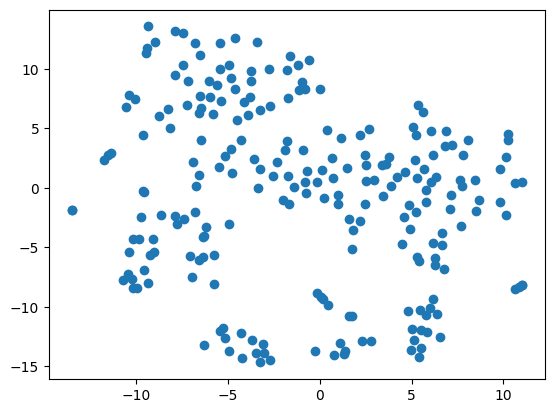

In [67]:
clean_tweets = []
for tweet in get_tweets:
        terms = get_tweets[tweet]['PreProcessed_Tweet']
        clean_tweets.append(terms)

model = Word2Vec(clean_tweets, workers=4, min_count=50, window=10, sample=1e-3)


X = model.wv[model.wv.index_to_key]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

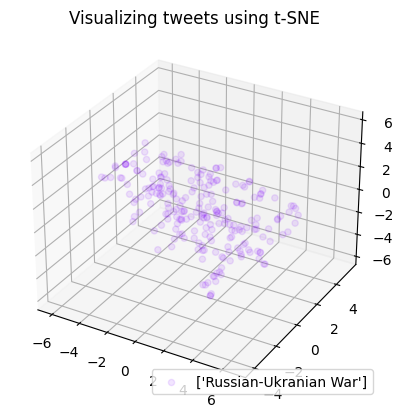

In [68]:
import matplotlib.cm as cm

model_wp = Word2Vec(clean_tweets, workers=4, min_count=50, window=10, sample=1e-3)

words_wp = []
embeddings_wp = []
for word in list(model_wp.wv.index_to_key):
    embeddings_wp.append(model_wp.wv[word])
    words_wp.append(word)

tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(np.array(embeddings_wp))  # Corrected line

from mpl_toolkits.mplot3d import Axes3D

def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = cm.rainbow(np.linspace(0, 1, len(label)))
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    ax.legend(loc=4)
    plt.title(title)
    plt.show()

tsne_plot_3d('Visualizing tweets using t-SNE', ['Russian-Ukranian War'], embeddings_wp_3d, a=0.1)
